In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nips-papers/paper_authors.csv
/kaggle/input/nips-papers/papers.csv
/kaggle/input/nips-papers/authors.csv
/kaggle/input/nips-papers/database.sqlite


In [22]:
pip install bertopic sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [23]:
import numpy as np
import random
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
import nltk
from sklearn.decomposition import NMF, TruncatedSVD
from gensim.models.ldamulticore import LdaMulticore
from sklearn.feature_extraction.text import TfidfVectorizer
from bertopic import BERTopic

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
papers = pd.read_csv('/kaggle/input/nips-papers/papers.csv')
papers.drop(columns=['id', 'event_type', 'pdf_name'], inplace=True)
papers.head()

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [5]:
papers = papers.sample(frac=0.3, random_state=42)    #using only 30% of the data for now

Text(0.5, 1.0, 'Machine Learning Publications since 1987')

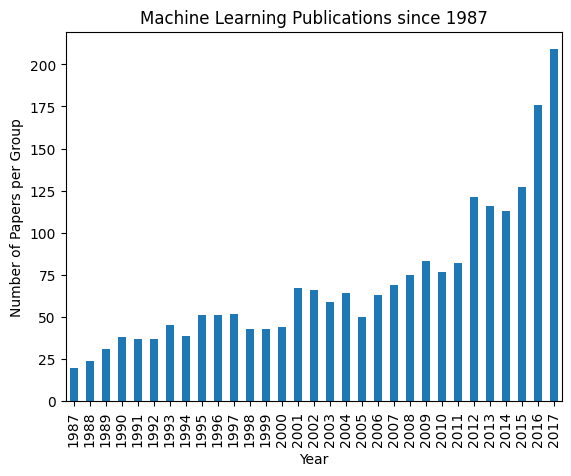

In [6]:
groups = papers.groupby('year')
counts = groups.size()
import matplotlib.pyplot as plt
%matplotlib inline
counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Papers per Group')
plt.title('Machine Learning Publications since 1987')

In [7]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [8]:
papers['text'] = papers['title'] + ' ' + papers['abstract'] + ' ' + papers['paper_text']
papers['text'] = papers['text'].str.lower()
papers['text'] = papers['text'].str.replace(r'[^a-z\s]', '', regex=True)
papers['tokens'] = papers['text'].apply(word_tokenize)

In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
papers['tokens'] = papers['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x if word not in stop_words and len(word) > 2])

In [10]:
dictionary = corpora.Dictionary(papers['tokens'])
dictionary.filter_extremes(no_below=10, no_above=0.5)  # Filter terms that appear less than 10 times
corpus = [dictionary.doc2bow(tokens) for tokens in papers['tokens']]
texts = papers['tokens']

In [11]:
def plot_coherence_values(model_type, coherence_values, limit, start=2, step=3):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.title(f"{model_type} Coherence Score")
    plt.show()

# LDA

In [12]:
def compute_lda_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=5, workers=4)  # Reduce passes and use multithreading
        model_list.append(model)
        
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

# Limit the number of topics and reduce steps for quicker runs
limit = 15  # Max number of topics to evaluate
start = 2
step = 3

# Compute LDA coherence values
lda_model_list, lda_coherence_values = compute_lda_coherence_values(dictionary=dictionary, corpus=corpus, 
                                                                    texts=texts, start=start, limit=limit, 
                                                                    step=step)

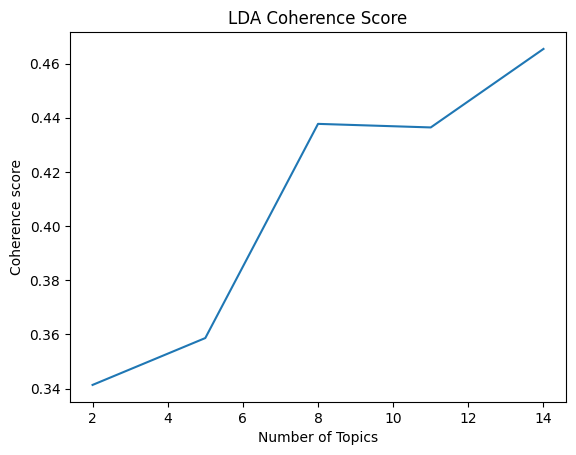

In [13]:
plot_coherence_values("LDA",lda_coherence_values,limit,start,step)

In [21]:
print(f"Best LDA Coherence Score: {max(lda_coherence_values)}")

Best LDA Coherence Score: 0.4654311200912832


# NMF

In [14]:
def compute_nmf_coherence_values(texts, dictionary, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        # Create the NMF model
        tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
        tfidf = tfidf_vectorizer.fit_transform([' '.join(text) for text in texts])
        model = NMF(n_components=num_topics, random_state=42)
        W = model.fit_transform(tfidf)
        model_list.append(model)

        # Extract topic terms and calculate coherence
        topic_words = []
        for topic_idx, topic in enumerate(model.components_):
            words = [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6:-1]]
            topic_words.append(words)

        # Compute coherence score
        coherence_model = CoherenceModel(topics=topic_words, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

# Create a Gensim dictionary from the tokenized texts
dictionary = corpora.Dictionary(texts)

# Compute NMF coherence values with the dictionary provided
nmf_model_list, nmf_coherence_values = compute_nmf_coherence_values(texts=texts, dictionary=dictionary, start=start, limit=limit, step=step)

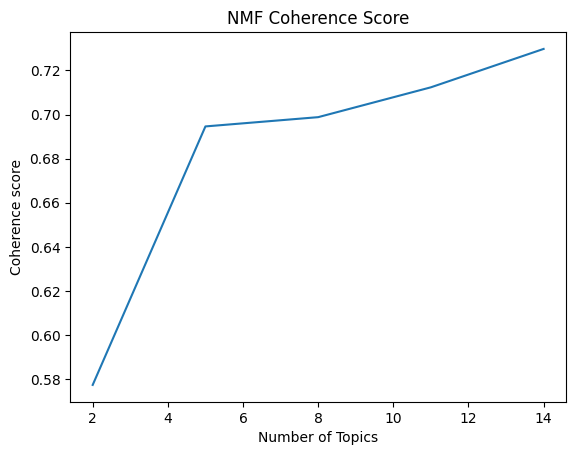

In [15]:
plot_coherence_values("NMF",nmf_coherence_values,limit,start,step)

In [20]:
print(f"Best NMF Coherence Score: {max(nmf_coherence_values)}")

Best NMF Coherence Score: 0.729785399410103


# LSA

In [16]:
def compute_lsa_coherence_values(texts, dictionary, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        # Create the LSA model
        tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
        tfidf = tfidf_vectorizer.fit_transform([' '.join(text) for text in texts])
        model = TruncatedSVD(n_components=num_topics)
        model.fit(tfidf)
        model_list.append(model)
        
        # Extract topic terms and calculate coherence
        topic_words = []
        for topic_idx, topic in enumerate(model.components_):
            words = [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6:-1]]
            topic_words.append(words)

        # Compute coherence score
        coherence_model = CoherenceModel(topics=topic_words, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

# Create a Gensim dictionary from the tokenized texts
dictionary = corpora.Dictionary(texts)

# Compute LSA coherence values with the dictionary provided
lsa_model_list, lsa_coherence_values = compute_lsa_coherence_values(texts=texts, dictionary=dictionary, start=start, limit=limit, step=step)

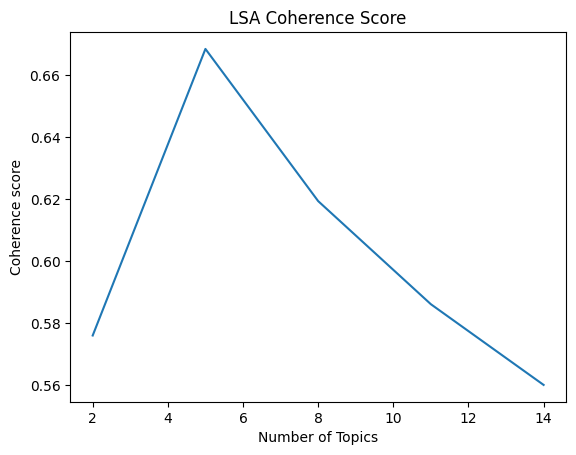

In [17]:
plot_coherence_values("LSA",lsa_coherence_values,limit,start,step)

In [19]:
print(f"Best LSA Coherence Score: {max(lsa_coherence_values)}")

Best LSA Coherence Score: 0.6683485626209131


# BERTopic

In [24]:
documents = [' '.join(text) for text in texts]

# Initialize BERTopic
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(documents)

topic_model.visualize_topics()

# Find the coherence score for BERTopic using c_v from Gensim
def compute_bertopic_coherence(model, texts, dictionary):
    topic_words = model.get_topics()

    topics_tokens = [[word[0] for word in topic_words[topic]] for topic in topic_words]

    coherence_model = CoherenceModel(topics=topics_tokens, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

coherence_score_bertopic = compute_bertopic_coherence(topic_model, texts, dictionary)
print(f"BERTopic Coherence Score: {coherence_score_bertopic}")

2024-10-06 09:55:24,534 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/68 [00:00<?, ?it/s]

2024-10-06 09:55:50,684 - BERTopic - Embedding - Completed ✓
2024-10-06 09:55:50,684 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-10-06 09:56:08,778 - BERTopic - Dimensionality - Completed ✓
2024-10-06 09:56:08,780 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-10-06 09:56:08,886 - BERTopic - Cluster - Completed ✓
2024-10-06 09:56:08,895 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-10-06 09:56:15,522 - BERTopic - Representation - Completed ✓
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fo

BERTopic Coherence Score: 0.5784125097440959
